In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper
from Utils.transform import cutOut

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
dimension = (128,128)
channels = 5
optimizer = Adam( lr = 1e-3 )
slices = [224,352,224,352]
slices_label = [32,64+32,32,64+32]
cutOutFrame = cutOut(slices)
cutOutFrame_label = cutOut(slices_label)

PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
TRANSFORMATION = [cutOutFrame_label]
tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true[:,:])
                           
def mixd(output):
    rate = tf.math.exp(output[0,:,:,0]) #A 
    s = tf.math.sigmoid(output[0,:,:,1])
    components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
     tfd.Poisson(rate=rate) #F 
     ]
    mixture = tfd.Mixture(
          cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
          components=components)
    
    return mixture
    
def testnetPoisson_2(input_shape,
           n_predictions=1,
           simpleclassification=None,
           flatten_output=False,
           activation_hidden="relu",
           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up02 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64
    up01 = MaxPooling2D((2, 2), strides=(2, 2))(up01)
    
    output = Conv2D(7, (1, 1), activation="selu")(up01)  # 1 x 64x64
    
    output = Flatten()(output)
    output = Dense(16*16)(output)
    output = Dropout(0.1)(output)
    output = Dense(64*64)(output)
    #output = Activation(tf.math.softplus)(output)
    
    output = tfp.layers.IndependentPoisson((64,64,1))(output)
    model = Model(inputs=inputs, outputs=output)
    return model

def provideData(flatten=False,dimension=dimension,batch_size=10,transform=TRANSFORMATION,preTransformation=PRETRAINING_TRANSFORMATIONS):

    getDataSet(DatasetFolder,year=[2017,2016,2015],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[],
                            transform=transform,
                            preTransformation=preTransformation)
    
    return train,test
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

In [3]:

optimizer = Adam( lr = 1e-4 )
batch_size=100
tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

train, test = provideData(flatten=False,dimension=dimension,batch_size=batch_size,transform=TRANSFORMATION,preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2017 => won't download this year again... please check for consistency
Found Year :  2016 => won't download this year again... please check for consistency
Found Year :  2015 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [4]:
t = Trainer(testnetPoisson_2,
                    NLL,
                    (train,test),
                    batch_size = batch_size,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

print(test[0][0].shape)
print(test[0][1].shape)
print("len train,val",len(train),len(test))

[Loaded file]  ./model_data/testnetPoisson_2_function/testnetPoisson_2_function128x128x5.h5
20
[Loaded file]  ./model_data/testnetPoisson_2_function/testnetPoisson_2_function128x128x5history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 10) 460         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 10) 0           conv2d[0][0]                     
________________________________________________________________________________________________

/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


In [ ]:
print(t.model(train[0][0]))
t.fit(20)



tfp.distributions.Independent("model_independent_poisson_IndependentPoisson_Independentmodel_independent_poisson_IndependentPoisson_Poisson", batch_shape=[100], event_shape=[64, 64, 1], dtype=float32)
Epoch 21/40
905/905 [==============================] - 208s 230ms/step - loss: 98.7597 - mse: 0.0079 - mae: 0.0130 - val_loss: 98.1208 - val_mse: 0.0093 - val_mae: 0.0145
Epoch 22/40
905/905 [==============================] - 204s 226ms/step - loss: 94.1887 - mse: 0.0074 - mae: 0.0128 - val_loss: 96.9610 - val_mse: 0.0074 - val_mae: 0.0129
Epoch 23/40
905/905 [==============================] - 203s 224ms/step - loss: 93.8115 - mse: 0.0073 - mae: 0.0127 - val_loss: 96.7329 - val_mse: 0.0078 - val_mae: 0.0132
Epoch 24/40
905/905 [==============================] - 203s 224ms/step - loss: 93.7106 - mse: 0.0073 - mae: 0.0127 - val_loss: 96.9340 - val_mse: 0.0079 - val_mae: 0.0133
Epoch 25/40
905/905 [==============================] - ETA: 0s - loss: 93.6343 - mse: 0.0073 - mae: 0.0127

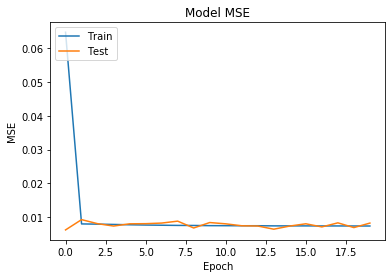

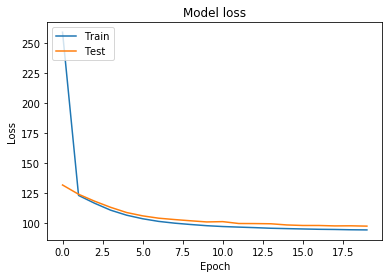

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = t.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()

In [6]:
model = t.model
pred = None
label = None
pred = 10
test.on_epoch_end()
mean = []
stdev = []
label = []
for x,y in test:
    for i in range(batch_size):
        if y[i,:,:,:].max() > 0:
            pred = model(np.array([x[i,:,:,:]]))
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
        #mean = model(x).mean()
        #std = model(x).stddev()
        #label = y
        break

/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:98: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


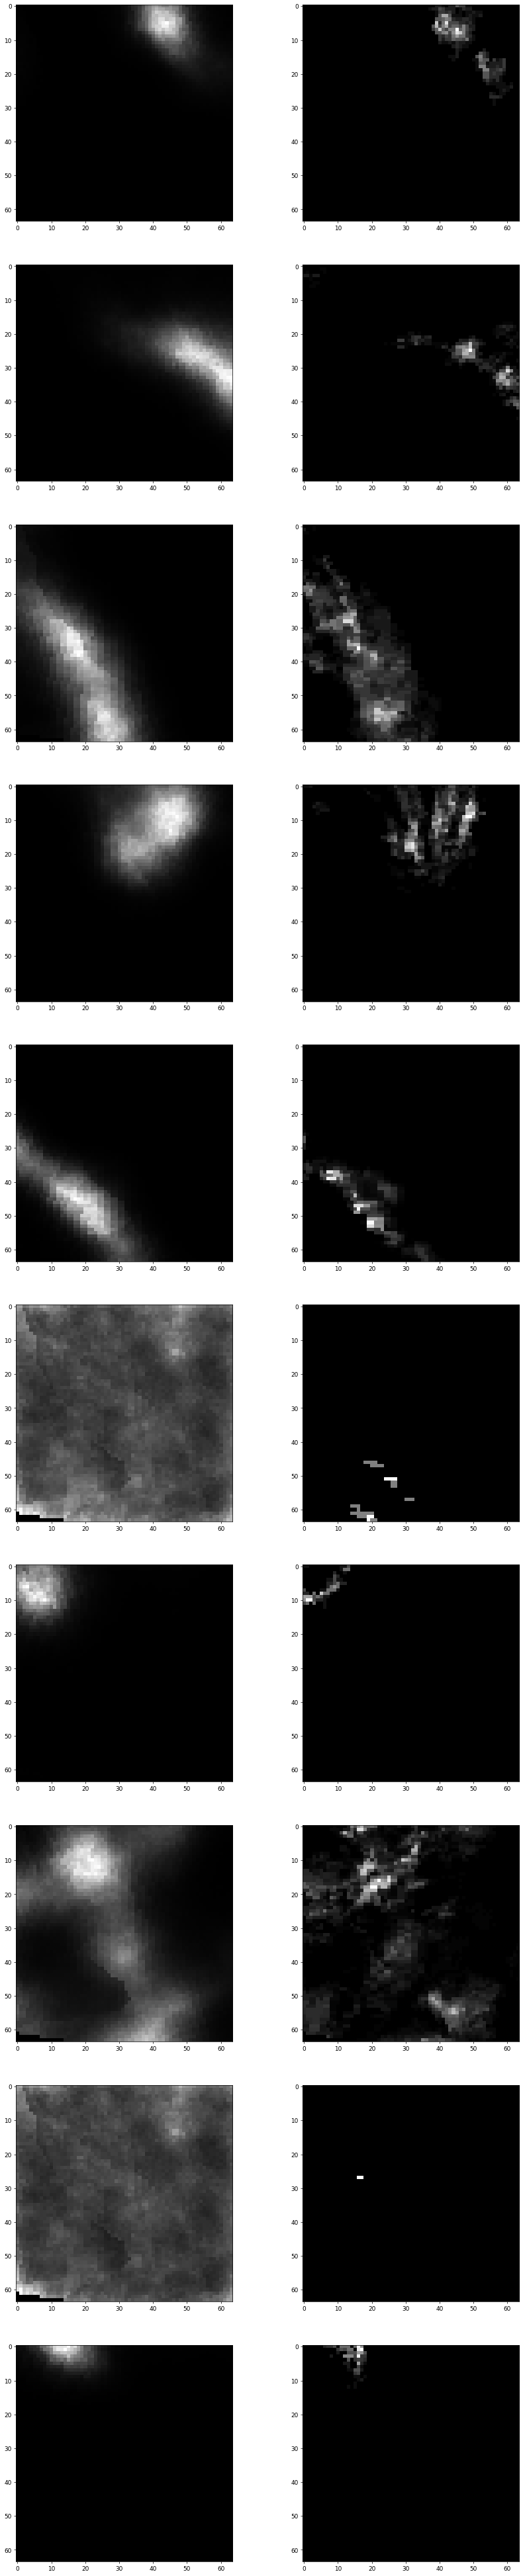

In [7]:
fig, axes = plt.subplots(10, 2, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 10:
        break
    axes[batch,0].imshow(img[0,:,:,0]*255.0,cmap="gray")
    #axes[batch,1].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,1].imshow(label[batch][:,:,0]*255.0,cmap="gray")